## Model Exercises - Based on Walkthrough
`Corey Solitaire`   
10.30.2020   

In [1]:
import requests
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import os
from env import host, user, password
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

## Wrangle:

In [2]:
# Call CSV
df = pd.read_csv('time_series_project.csv')
# Convert to Datetime
df.date = pd.to_datetime(df.date)
# Reset Index
df = df.set_index('date').sort_index()
df = df.dropna()

In [3]:
df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [4]:
df.tail()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-12-02,3957.0,13257.0,6.23,195.0,725.0,265.0,13.0,70.0,2305.0
2018-12-03,3660.0,12915.0,6.12,6.0,782.0,219.0,40.0,51.0,1993.0
2018-12-04,3384.0,13763.0,6.49,13.0,608.0,199.0,11.0,67.0,1663.0
2018-12-05,3670.0,13865.0,6.52,12.0,739.0,200.0,12.0,69.0,1968.0
2018-12-06,3669.0,14774.0,6.96,9.0,647.0,198.0,4.0,78.0,1962.0


In [5]:
df.shape

(225, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   calories_burned     225 non-null    float64
 1   steps               225 non-null    float64
 2   distance            225 non-null    float64
 3   floors              225 non-null    float64
 4   mins_sedentary      225 non-null    float64
 5   mins_light_active   225 non-null    float64
 6   mins_fairly_active  225 non-null    float64
 7   mins_very_active    225 non-null    float64
 8   activity_calories   225 non-null    float64
dtypes: float64(9)
memory usage: 17.6 KB


<div class="alert alert-block alert-info"><b></b></div>

# Explore:

Split:

    1. We will use the training proprtion method to split
    2. Identify lenght of df, mult by train_prop to get the number of rows. x = train_prop * 100
    3. Select row indicies
    4. Return train and test dataframes

<div class="alert alert-block alert-info"><b></b></div>

In [7]:
train_size = int(len(df)*.5)
train_size

112

In [8]:
validate_size = int(len(df)*.3)
validate_size

67

In [9]:
test_size = int(len(df) - train_size - validate_size)
test_size

46

In [10]:
# Verify all data is accounted for
validate_end_index = train_size + validate_size
validate_end_index

179

#### Use Values to Split Data Frame

In [11]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

#### Verify Splits

**Does the length of each df equate to the length of the original df?**

In [12]:
print(len(train) + len(validate) + len(test) == len(df))

True


**Does the first row of original df equate to the first row of train?**


In [13]:
print(df.head(1) == train.head(1))

            calories_burned  steps  distance  floors  mins_sedentary  \
date                                                                   
2018-04-26             True   True      True    True            True   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-04-26               True                True              True   

            activity_calories  
date                           
2018-04-26               True  


**Is the last row of train the day before the first row of validate? And the same for validate to test?**

In [14]:
pd.concat([train.tail(1), validate.head(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-15,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-16,3490.0,8039.0,3.79,18.0,877.0,311.0,7.0,6.0,1678.0


In [15]:
pd.concat([validate.tail(1), test.head(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-10-21,3991.0,16642.0,7.85,15.0,437.0,349.0,33.0,58.0,2485.0
2018-10-22,3149.0,8328.0,3.93,7.0,747.0,172.0,4.0,28.0,1239.0


**Is the last row of test the same as the last row of our original dataframe?**

In [16]:
pd.concat([test.tail(1), df.tail(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-12-06,3669.0,14774.0,6.96,9.0,647.0,198.0,4.0,78.0,1962.0
2018-12-06,3669.0,14774.0,6.96,9.0,647.0,198.0,4.0,78.0,1962.0


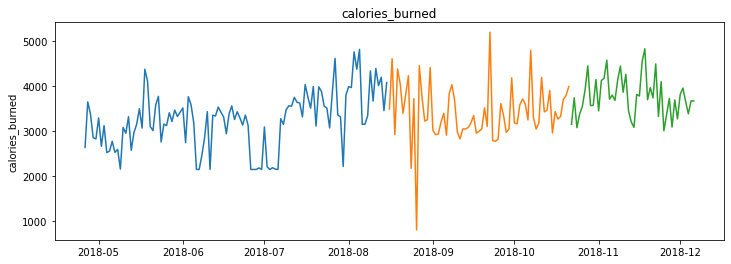

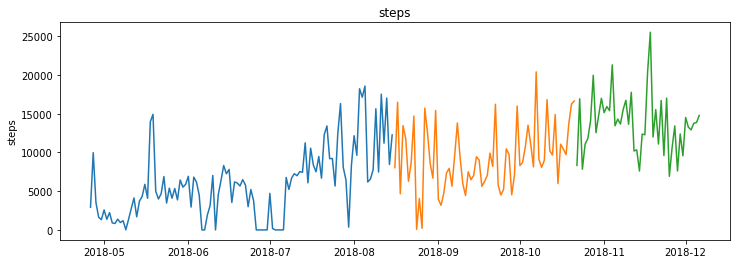

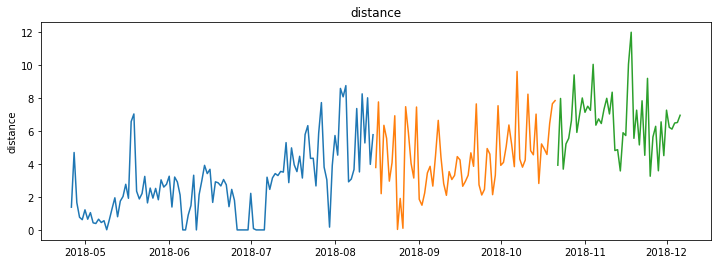

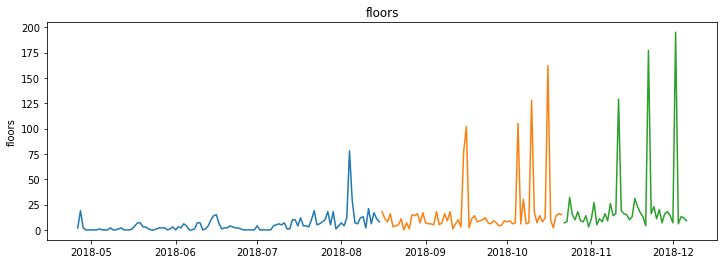

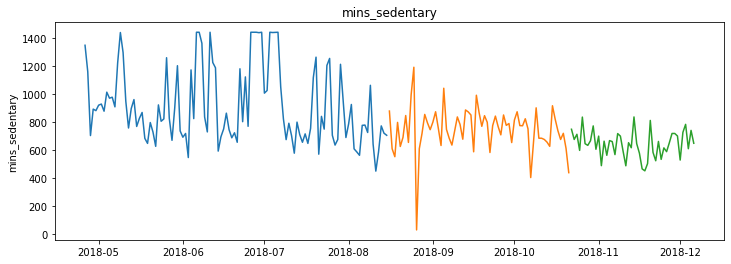

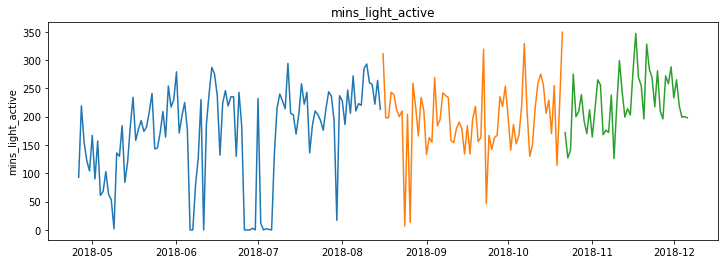

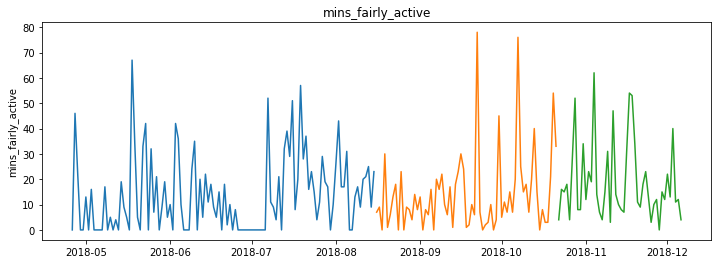

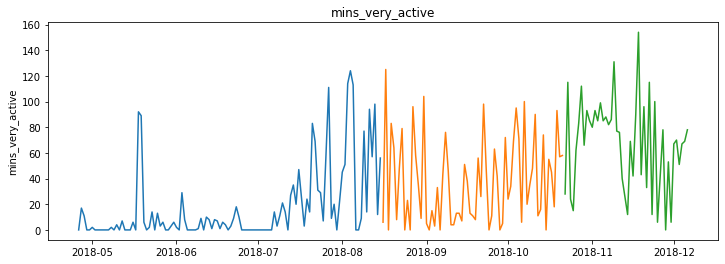

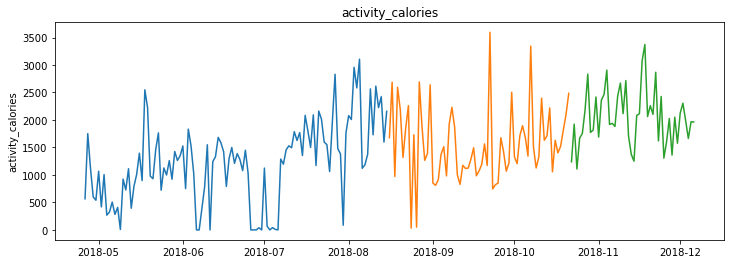

In [17]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### Create Evaluate Functions

In [18]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [19]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [20]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [21]:
# Verify Functions Work Properly
eval_df

,model_type,target_var,rmse


<div class="alert alert-block alert-info"><b></b></div>

# Forecast

Forecasting is another word for predicting time series data.

    Last Observed Value
    Simple Average
    Moving Average
    Holt's Linear Trend
    Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

## Last Observed Value

<div class="alert alert-block alert-info"><b></b></div>

In [22]:
list = list(train.columns)
list

['calories_burned',
 'steps',
 'distance',
 'floors',
 'mins_sedentary',
 'mins_light_active',
 'mins_fairly_active',
 'mins_very_active',
 'activity_calories']

#### Make Predictions

In [23]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'][-1:][0], 2)
# steps prediction
steps = round(train['steps'][-1:][0], 2)
# distance prediction
distance = round(train['distance'][-1:][0], 2)
# floors prediction
floors = round(train['floors'][-1:][0], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'][-1:][0], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'][-1:][0], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'][-1:][0], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'][-1:][0], 2)
# activity_calories
activity_calories = round(train['activity_calories'][-1:][0], 2)

#### Apply Predictions to Observations

In [24]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-16,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-17,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-18,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-19,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0
2018-08-20,4079.0,12259.0,5.78,8.0,704.0,213.0,23.0,56.0,2158.0


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 921


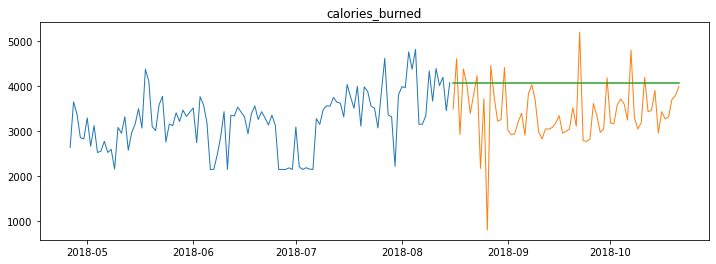

steps -- RMSE: 5156


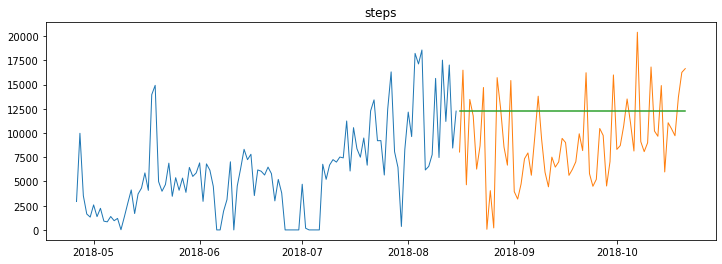

distance -- RMSE: 2


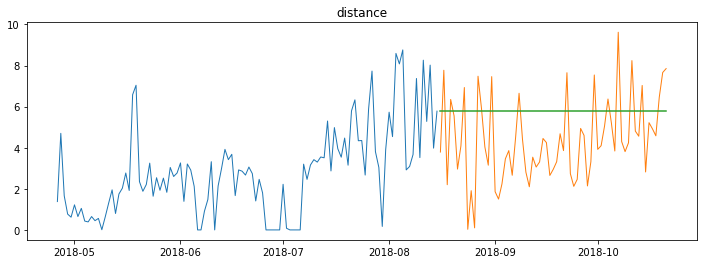

floors -- RMSE: 31


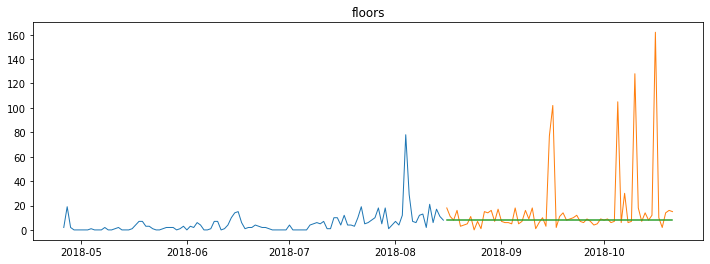

mins_sedentary -- RMSE: 163


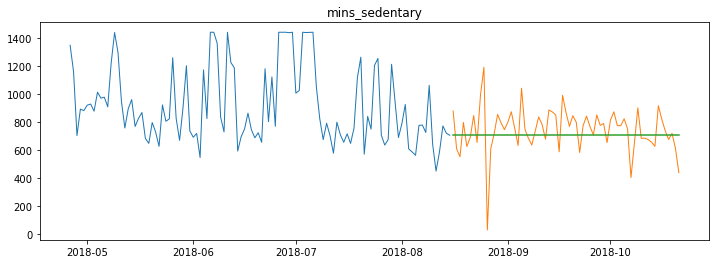

mins_light_active -- RMSE: 64


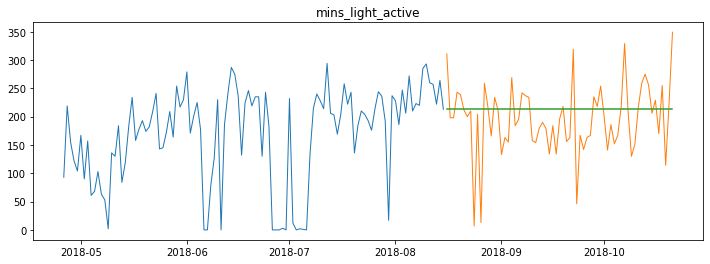

mins_fairly_active -- RMSE: 18


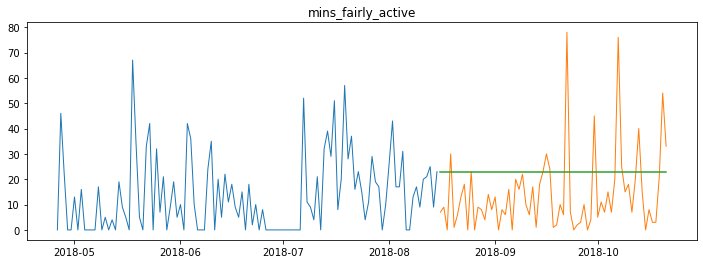

mins_very_active -- RMSE: 38


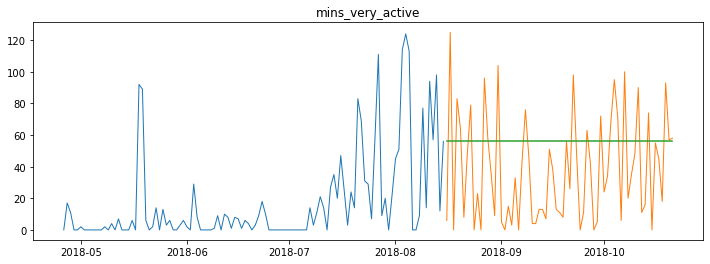

activity_calories -- RMSE: 897


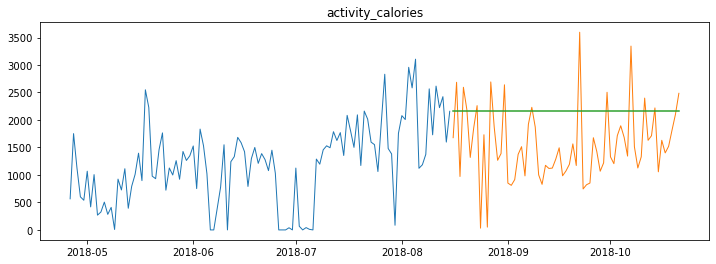

In [25]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [26]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,mins_sedentary,163.0
5,last_observed_value,mins_light_active,64.0
6,last_observed_value,mins_fairly_active,18.0
7,last_observed_value,mins_very_active,38.0
8,last_observed_value,activity_calories,897.0


***

**Takeaway:**

`The last vale in Train just happened to be a day where this individual stopped their regular pattern of behavior.  RMSE is very hight, average line is far from validate, model demonstrate low perdictive value`

***

<div class="alert alert-block alert-info"><b></b></div>

## Simple Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [27]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'].mean(), 2)
# steps prediction
steps = round(train['steps'].mean(), 2)
# distance prediction
distance = round(train['distance'].mean(), 2)
# floors prediction
floors = round(train['floors'].mean(), 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].mean(), 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].mean(), 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].mean(), 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].mean(), 2)
# activity_calories
activity_calories = round(train['activity_calories'].mean(), 2)

#### Apply Predictions to Observations

In [28]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-17,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-18,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-19,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-20,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 658


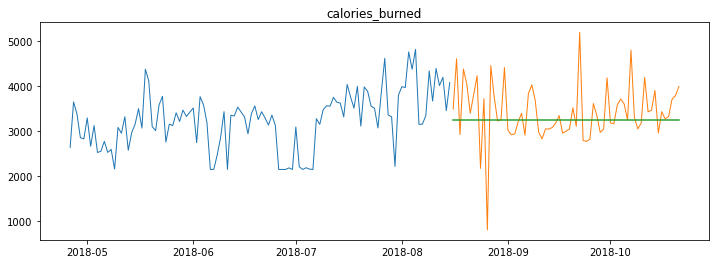

steps -- RMSE: 5356


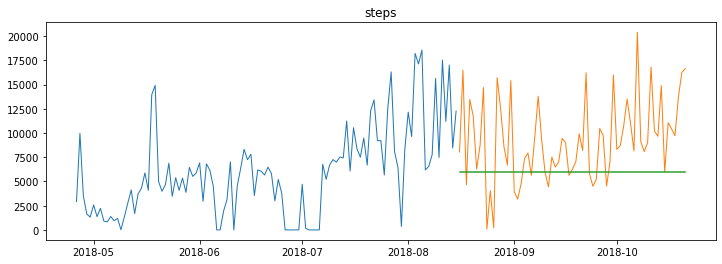

distance -- RMSE: 3


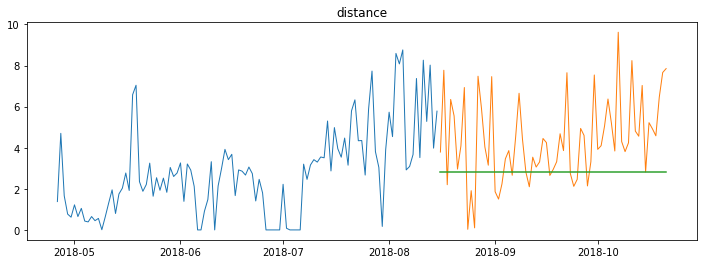

floors -- RMSE: 32


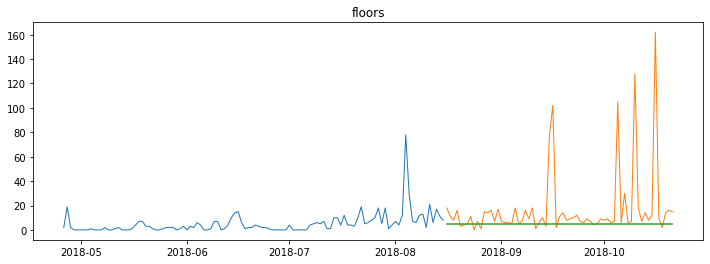

mins_sedentary -- RMSE: 233


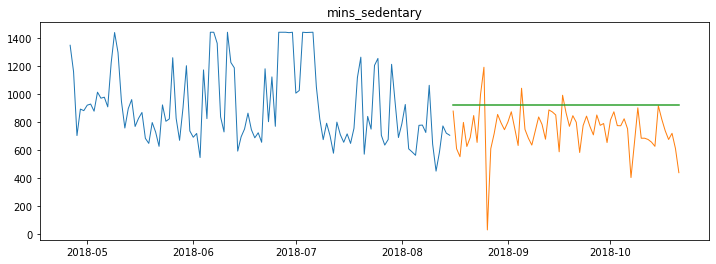

mins_light_active -- RMSE: 68


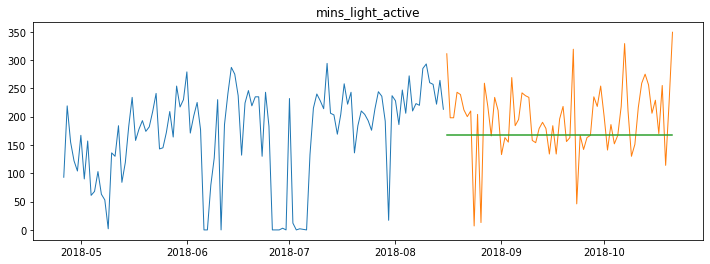

mins_fairly_active -- RMSE: 16


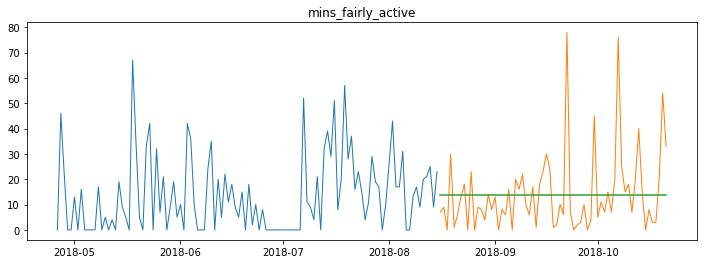

mins_very_active -- RMSE: 39


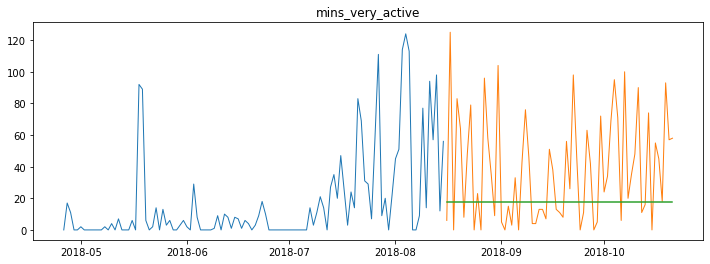

activity_calories -- RMSE: 746


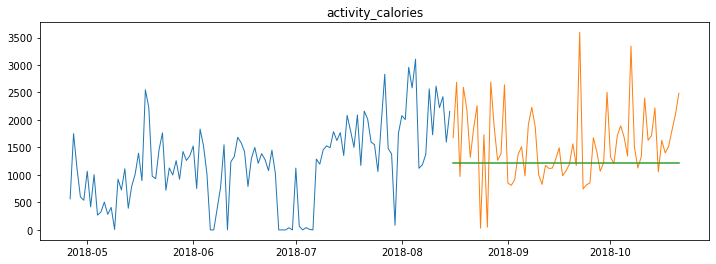

In [29]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df.sort_values('rmse')

,model_type,target_var,rmse
2,last_observed_value,distance,2.0
11,simple_average,distance,3.0
15,simple_average,mins_fairly_active,16.0
6,last_observed_value,mins_fairly_active,18.0
3,last_observed_value,floors,31.0
12,simple_average,floors,32.0
7,last_observed_value,mins_very_active,38.0
16,simple_average,mins_very_active,39.0
5,last_observed_value,mins_light_active,64.0
14,simple_average,mins_light_active,68.0


***

**Takeaway:**

`Simple average has lower RMSE than last observed value. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Moving Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [31]:
# 30 Day Rolling average (notice monthly seasonality)

period = 30 

# calories_burned Prediction
calories_burned  = round(train['calories_burned'].rolling(period).mean()[-1], 2)
# steps prediction
steps = round(train['steps'].rolling(period).mean()[-1], 2)
# distance prediction
distance = round(train['distance'].rolling(period).mean()[-1], 2)
# floors prediction
floors = round(train['floors'].rolling(period).mean()[-1], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].rolling(period).mean()[-1], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].rolling(period).mean()[-1], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].rolling(period).mean()[-1], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].rolling(period).mean()[-1], 2)
# activity_calories
activity_calories = round(train['activity_calories'].rolling(period).mean()[-1], 2)

#### Apply Predictions to Observations

In [32]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-17,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-18,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-19,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-20,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 732


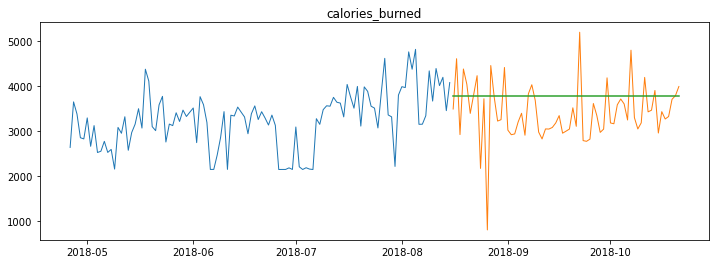

steps -- RMSE: 4425


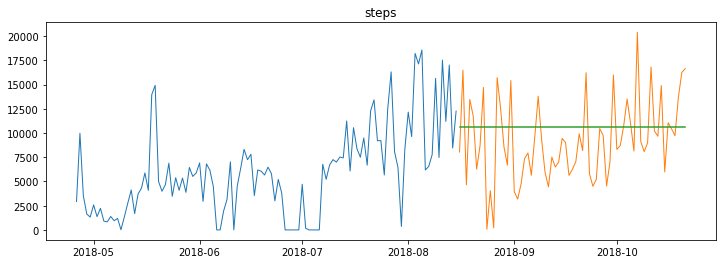

distance -- RMSE: 2


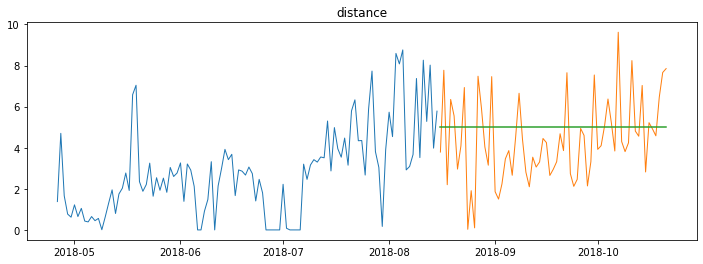

floors -- RMSE: 30


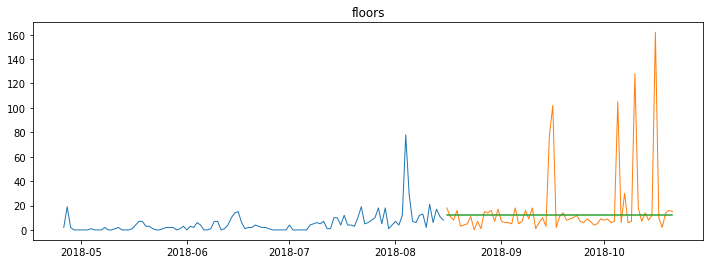

mins_sedentary -- RMSE: 166


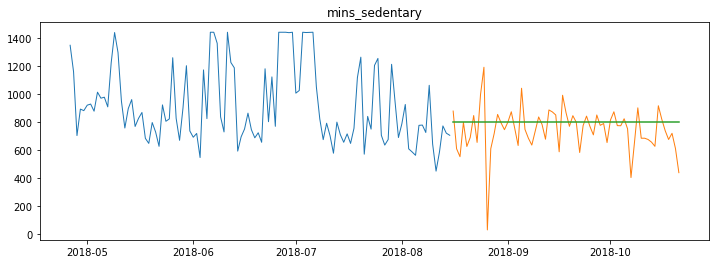

mins_light_active -- RMSE: 66


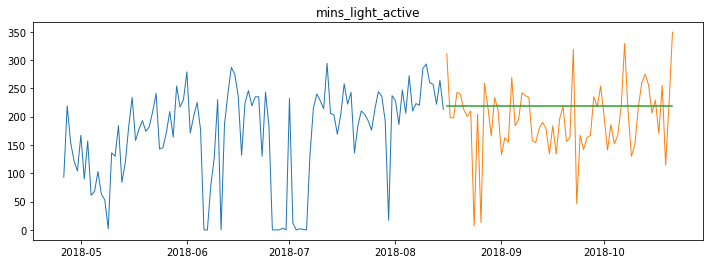

mins_fairly_active -- RMSE: 16


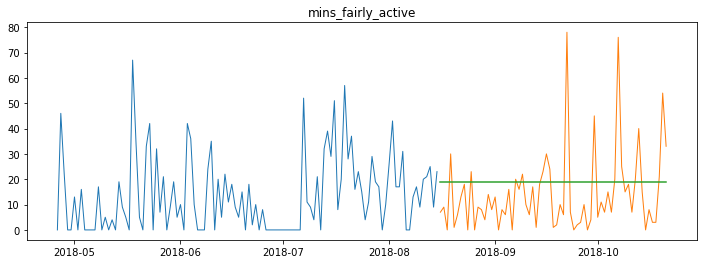

mins_very_active -- RMSE: 34


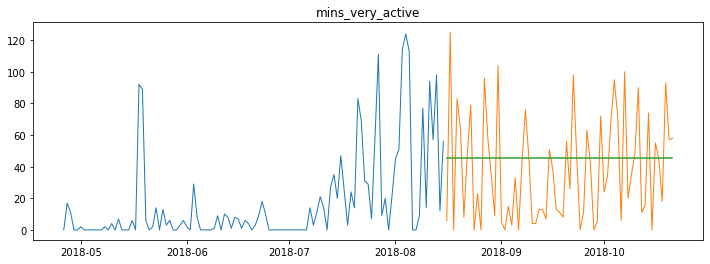

activity_calories -- RMSE: 736


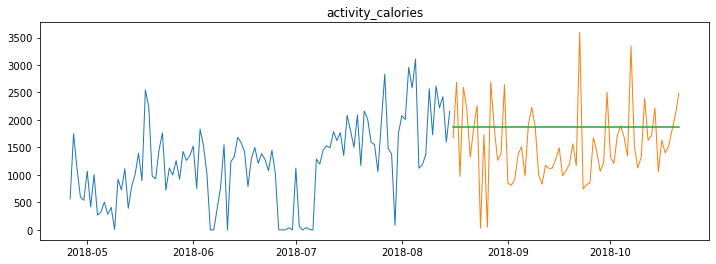

In [33]:
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df.sort_values('rmse')

,model_type,target_var,rmse
20,30d_moving_avg,distance,2.0
2,last_observed_value,distance,2.0
11,simple_average,distance,3.0
24,30d_moving_avg,mins_fairly_active,16.0
15,simple_average,mins_fairly_active,16.0
6,last_observed_value,mins_fairly_active,18.0
21,30d_moving_avg,floors,30.0
3,last_observed_value,floors,31.0
12,simple_average,floors,32.0
25,30d_moving_avg,mins_very_active,34.0


***

**Takeaway:**

`30 Day moving average has lower RMSE than simple average. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Holt's Linear Trend

<div class="alert alert-block alert-info"><b></b></div>


#### Seasonal Decomposition

`First, let's take a look at the seasonal decomposition for each target.`


calories_burned 



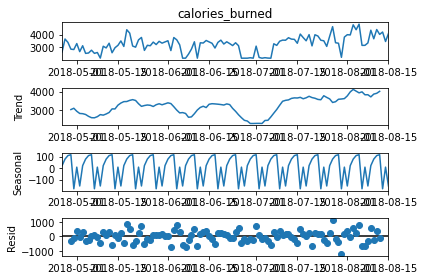

steps 



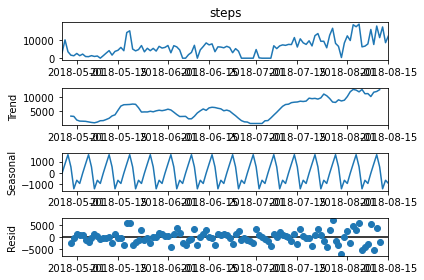

distance 



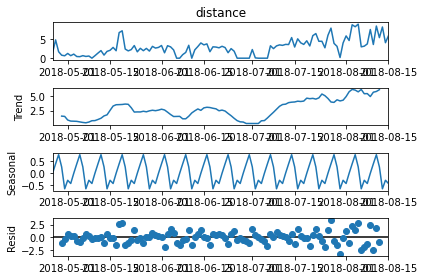

floors 



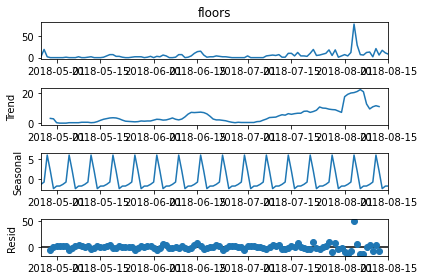

mins_sedentary 



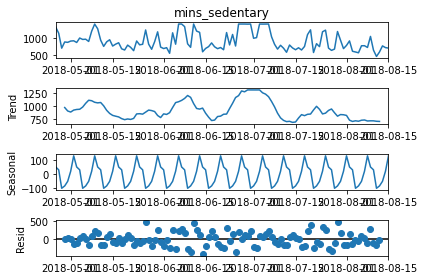

mins_light_active 



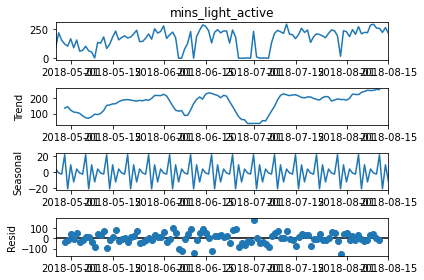

mins_fairly_active 



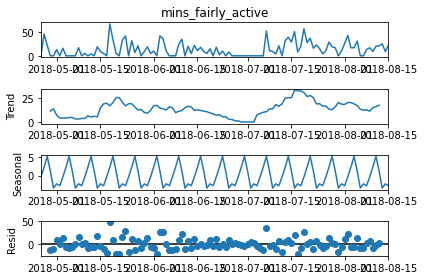

mins_very_active 



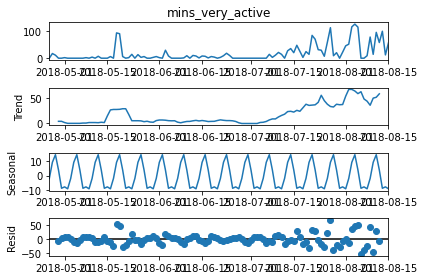

activity_calories 



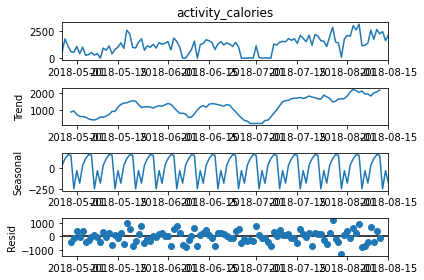

In [62]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('D').mean()).plot()
    plt.show()

#### Make Predictions

In [63]:
for col in train.columns:
    model = Holt(train[col], exponential = False, damped=True)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency informati

In [64]:
yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Apply Predictions to Observations

#### Plot Actual Vs. Predicted Values

#### Evauate

<div class="alert alert-block alert-info"><b></b></div>

## Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

### Resame Data w/30 Days Splits (Train,Validate,Test)  - have 30 extra days to use to predict on train

#### Make Predictions

In [37]:
train = df[:'2018-10-08']
validate = df.loc['2018-10-08':'2018-11-06']
test = df.loc['2018-11-07':'2018-12-06']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(166, 9)
(30, 9)
(30, 9)


,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [38]:
train.tail(1)

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-10-08,3299.0,9111.0,4.3,6.0,648.0,210.0,25.0,20.0,1513.0


#### Apply Predictions to Observations

In [39]:
yhat_df = train['2018-09-09':'2018-10-08'] + train.diff(30).mean()

In [40]:
pd.concat([yhat_df.head(1), validate.head(1)])

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-09-09,3741.772059,10452.897059,4.925515,12.382353,701.0,244.617647,22.852941,51.742647,1989.183824
2018-10-08,3299.000000,9111.000000,4.300000,6.000000,648.0,210.000000,25.000000,20.000000,1513.000000


In [41]:
# set yhat_df to index of validate

yhat_df.index = validate.index

yhat_df.describe()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,3396.905392,9949.430392,4.692515,20.582353,735.900000,197.084314,17.019608,40.609314,1578.317157
std,558.816220,3702.009042,1.745637,27.090398,113.370114,54.622676,19.560839,31.102426,664.593250
min,2830.772059,5538.897059,2.615515,4.382353,369.000000,56.617647,0.852941,5.742647,862.183824
25%,3068.272059,7398.147059,3.493015,9.382353,705.000000,167.117647,5.102941,14.492647,1202.183824
50%,3230.772059,9338.897059,4.405515,11.882353,745.000000,189.617647,10.852941,30.742647,1370.683824
75%,3627.022059,10970.647059,5.175515,14.132353,810.250000,226.617647,22.352941,60.492647,1766.183824
max,5258.772059,21488.897059,10.135515,108.382353,957.000000,339.617647,78.852941,105.742647,3713.183824


#### Plot and Evaluate

calories_burned -- RMSE: 664


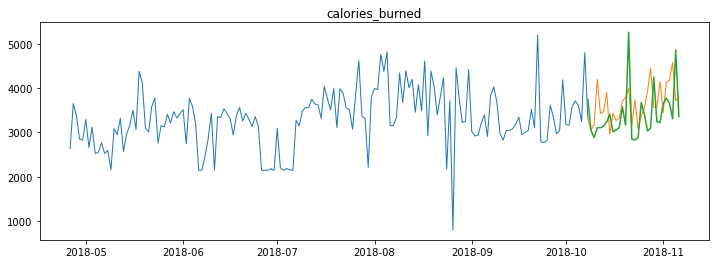

steps -- RMSE: 5512


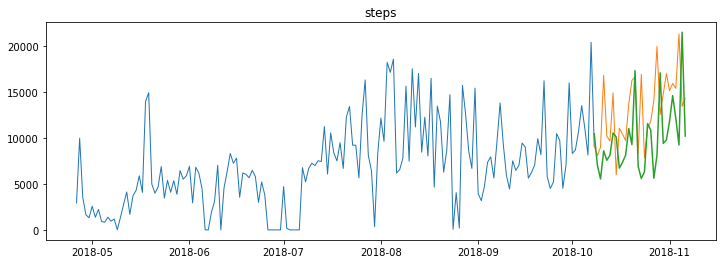

distance -- RMSE: 3


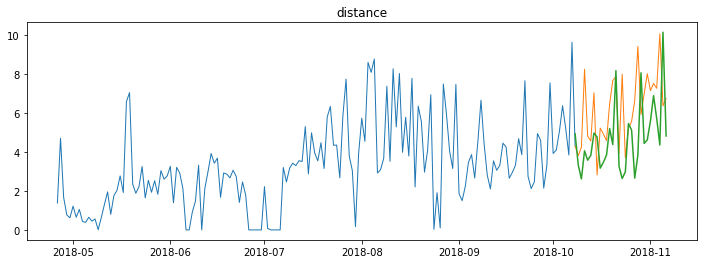

floors -- RMSE: 47


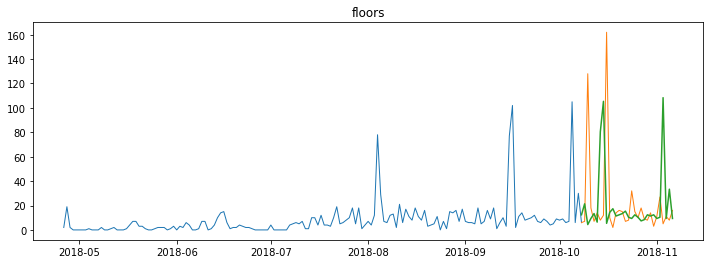

mins_sedentary -- RMSE: 145


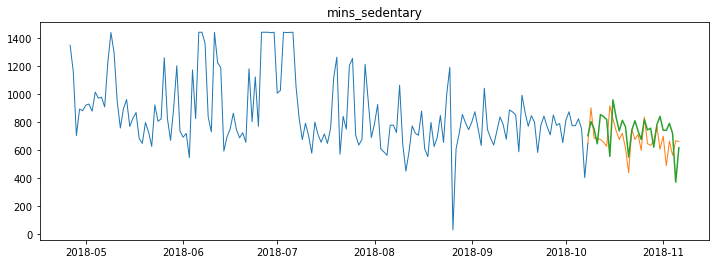

mins_light_active -- RMSE: 64


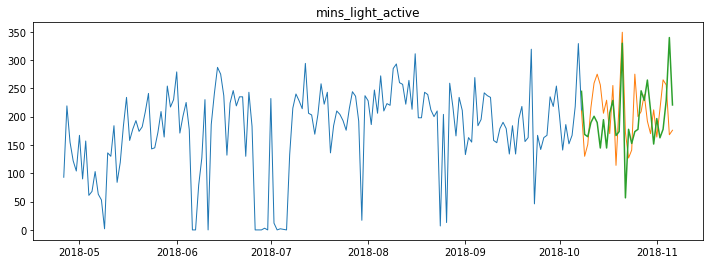

mins_fairly_active -- RMSE: 25


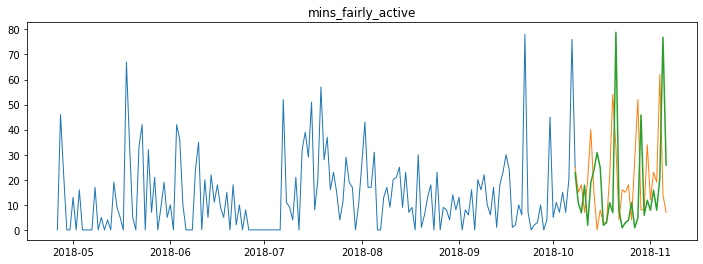

mins_very_active -- RMSE: 47


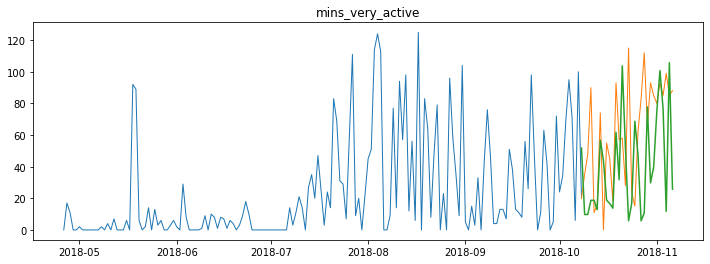

activity_calories -- RMSE: 756


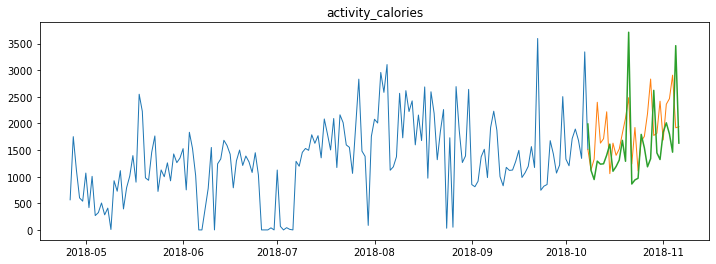

In [42]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_cycle", 
                            target_var = col)

<div class="alert alert-block alert-info"><b></b></div>

## Model Evaluation (Train):

<div class="alert alert-block alert-info"><b></b></div>

#### Which model did the best?

In [43]:

calories_burned_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]
steps_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]
distance_min_rmse = eval_df.groupby('target_var')['rmse'].min()[2]
floors_min_rmse = eval_df.groupby('target_var')['rmse'].min()[3]
mins_sedentary_min_rmse = eval_df.groupby('target_var')['rmse'].min()[4]
mins_light_active_min_rmse = eval_df.groupby('target_var')['rmse'].min()[5]
mins_fairly_active_min_rmse = eval_df.groupby('target_var')['rmse'].min()[6]
mins_very_active_min_rmse = eval_df.groupby('target_var')['rmse'].min()[7]
activity_calories_min_rmse = eval_df.groupby('target_var')['rmse'].min()[8]

# find which model that is
eval_df[((eval_df.rmse == calories_burned_min_rmse) | 
         (eval_df.rmse == steps_min_rmse) |
         (eval_df.rmse == distance_min_rmse) |
         (eval_df.rmse == floors_min_rmse) |
         (eval_df.rmse == mins_sedentary_min_rmse) |
         (eval_df.rmse == mins_light_active_min_rmse ) |
         (eval_df.rmse == mins_fairly_active_min_rmse) |
         (eval_df.rmse == mins_very_active_min_rmse) |
         (eval_df.rmse == activity_calories_min_rmse))]


,model_type,target_var,rmse
2,last_observed_value,distance,2.0
5,last_observed_value,mins_light_active,64.0
9,simple_average,calories_burned,658.0
15,simple_average,mins_fairly_active,16.0
19,30d_moving_avg,steps,4425.0
20,30d_moving_avg,distance,2.0
21,30d_moving_avg,floors,30.0
24,30d_moving_avg,mins_fairly_active,16.0
25,30d_moving_avg,mins_very_active,34.0
26,30d_moving_avg,activity_calories,736.0


<div class="alert alert-block alert-info"><b></b></div>

## Test:

<div class="alert alert-block alert-info"><b></b></div>

In [46]:
# Resample, Not Using Previous Cycle

train_size = int(len(df)*.5)
validate_size = int(len(df)*.3)
test_size = int(len(df) - train_size - validate_size)

train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

#### Make Predictions ( Each feature has a specific model that words best, we will test using specific modeling)

In [47]:
#(Simple Averge)
# calories_burned Prediction 
calories_burned  = round(train['calories_burned'].mean(), 2)

#(30 Day Moving Average)
period = 30
# steps prediction
steps = round(train['steps'].rolling(period).mean()[-1], 2)
# distance prediction
distance = round(train['distance'].rolling(period).mean()[-1], 2)
# floors prediction
floors = round(train['floors'].rolling(period).mean()[-1], 2)
# mins_sedentary
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].rolling(period).mean()[-1], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].rolling(period).mean()[-1], 2)
# activity_calories
activity_calories = round(train['activity_calories'].rolling(period).mean()[-1], 2)

#(last Observed Value)
# mins_light_active
mins_light_active = round(train['mins_light_active'][-1:][0], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'][-1:][0], 2)

#### Apply Predictions to Observations

In [48]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = test.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-10-22,3246.8,10650.63,5.02,12.0,704.0,213.0,18.83,45.63,1872.93
2018-10-23,3246.8,10650.63,5.02,12.0,704.0,213.0,18.83,45.63,1872.93
2018-10-24,3246.8,10650.63,5.02,12.0,704.0,213.0,18.83,45.63,1872.93
2018-10-25,3246.8,10650.63,5.02,12.0,704.0,213.0,18.83,45.63,1872.93
2018-10-26,3246.8,10650.63,5.02,12.0,704.0,213.0,18.83,45.63,1872.93


In [49]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [50]:

rmse_calories_burned = sqrt(mean_squared_error(test['calories_burned'], 
                                       yhat_df['calories_burned']))

rmse_steps = sqrt(mean_squared_error(test['steps'], 
                                       yhat_df['steps']))

rmse_distance = sqrt(mean_squared_error(test['distance'], 
                                       yhat_df['distance']))

rmse_floors = sqrt(mean_squared_error(test['floors'], 
                                       yhat_df['floors']))

rmse_mins_sedentary = sqrt(mean_squared_error(test['mins_sedentary'], 
                                       yhat_df['mins_sedentary']))

rmse_mins_light_active = sqrt(mean_squared_error(test['mins_light_active'], 
                                       yhat_df['mins_light_active']))

rmse_mins_fairly_active = sqrt(mean_squared_error(test['mins_fairly_active'], 
                                       yhat_df['mins_fairly_active']))

rmse_mins_very_active = sqrt(mean_squared_error(test['mins_very_active'], 
                                       yhat_df['mins_very_active']))

rmse_activity_calories= sqrt(mean_squared_error(test['activity_calories'], 
                                       yhat_df['activity_calories']))


In [53]:
print('rmse_calories_burned: ', rmse_calories_burned)
print('rmse_steps: ', rmse_steps)
print('rmse_distance: ', rmse_distance)
print('rmse_floors: ', rmse_floors)
print('rmse_sedentary: ', rmse_mins_sedentary)
print('rmse_light_active: ', rmse_mins_light_active)
print('rmse_fairly_active: ', rmse_mins_fairly_active)
print('rmse_very_active: ', rmse_mins_very_active)
print('rmse_activity_calories: ', rmse_activity_calories)

rmse_calories_burned:  677.7161044721228
rmse_steps:  4848.756303822303
rmse_distance:  2.372842269259086
rmse_floors:  40.79135671448911
rmse_sedentary:  112.97431412570697
rmse_light_active:  50.89204259999789
rmse_fairly_active:  15.174771253916669
rmse_very_active:  40.91736566597951
rmse_activity_calories:  531.3397141721308


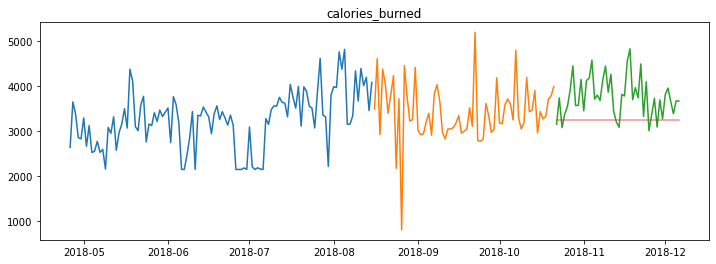

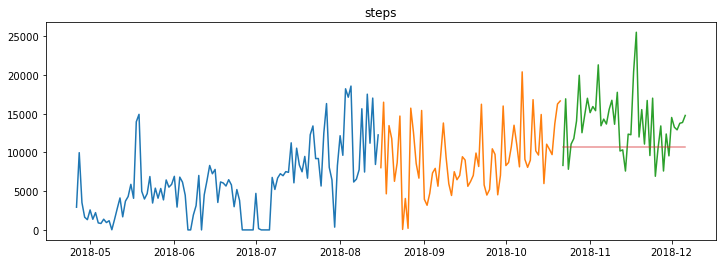

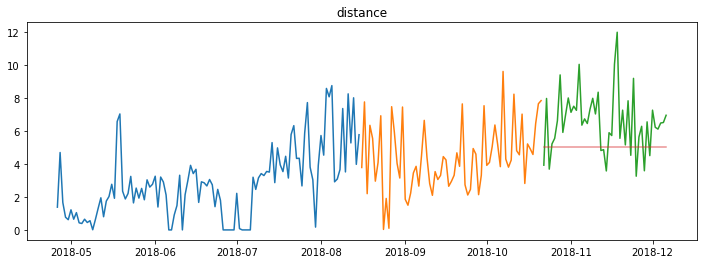

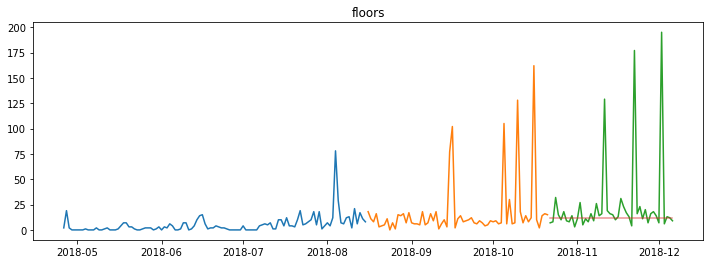

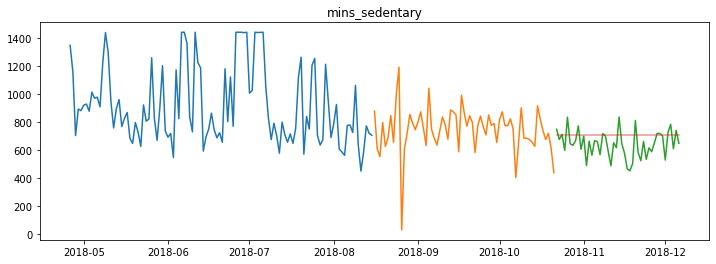

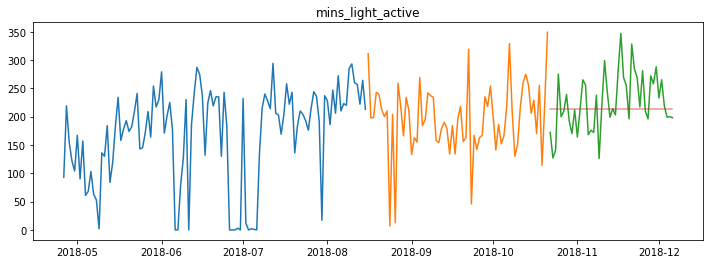

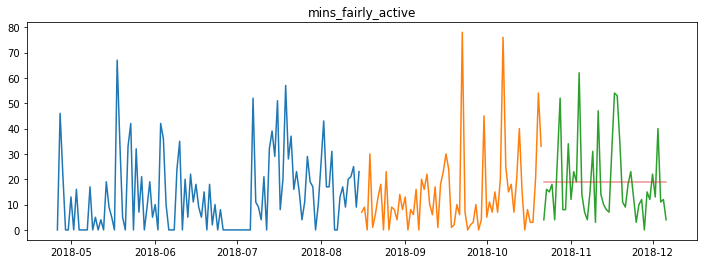

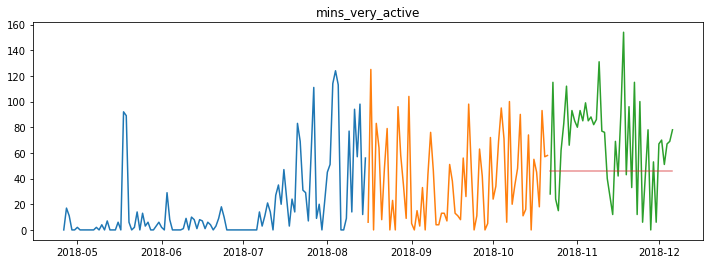

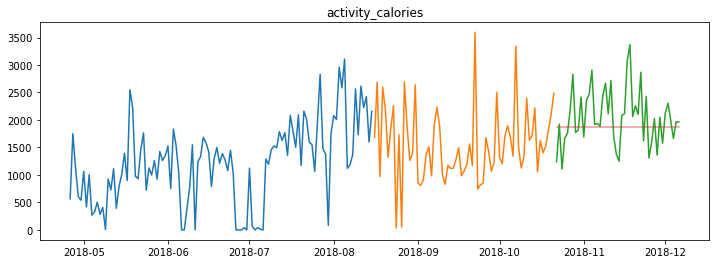

In [55]:
# Visualize
for col in train.columns:
    final_plot(col)

<div class="alert alert-block alert-info"><b></b></div>

## Predict Missing 2 Weeks:

<div class="alert alert-block alert-info"><b></b></div>

In [57]:
yhat_df = test + train.diff(14).mean()

yhat_df.index = test.index + pd.Timedelta('2W')

In [59]:
yhat_df

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-11-05,3314.112245,9784.510204,4.616939,9.040816,702.704082,191.397959,5.336735,36.030612,1450.979592
2018-11-06,3904.112245,18374.510204,8.666939,10.040816,629.704082,146.397959,17.336735,123.030612,2135.979592
2018-11-07,3240.112245,9285.510204,4.376939,34.040816,666.704082,160.397959,16.336735,32.030612,1319.979592
2018-11-08,3544.112245,12529.510204,5.906939,17.040816,551.704082,294.397959,19.336735,23.030612,1880.979592
2018-11-09,3714.112245,13244.510204,6.246939,12.040816,789.704082,219.397959,5.336735,70.030612,1967.979592
2018-11-10,4080.112245,15515.510204,7.316939,20.040816,599.704082,228.397959,29.336735,91.030612,2392.979592
2018-11-11,4615.112245,21412.510204,10.096939,11.040816,587.704082,258.397959,53.336735,120.030612,3045.979592
2018-11-12,3731.112245,14000.510204,6.606939,10.040816,620.704082,211.397959,9.336735,74.030612,1985.979592
2018-11-13,3737.112245,16250.510204,7.666939,16.040816,726.704082,189.397959,9.336735,101.030612,2028.979592


In [60]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

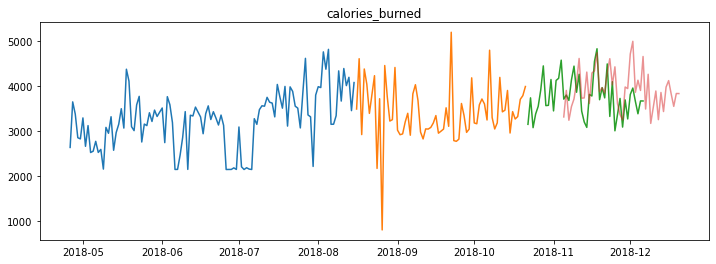

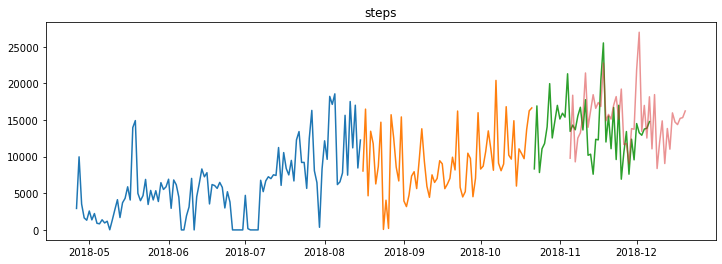

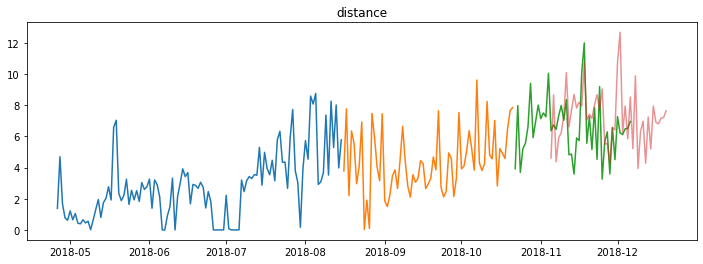

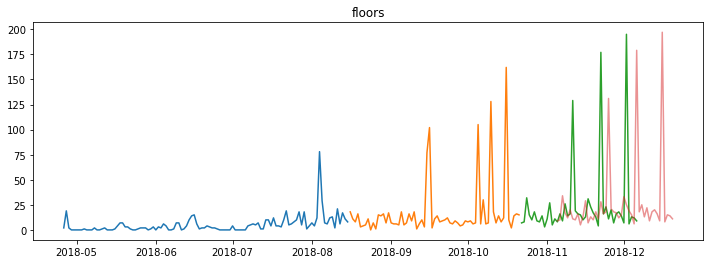

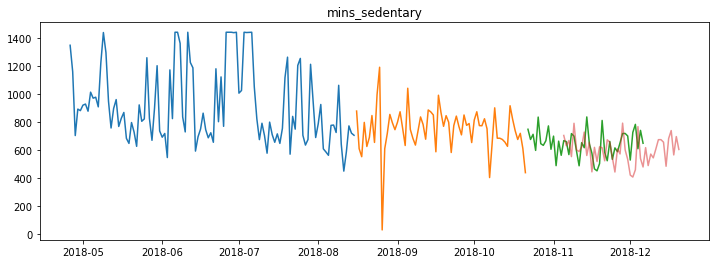

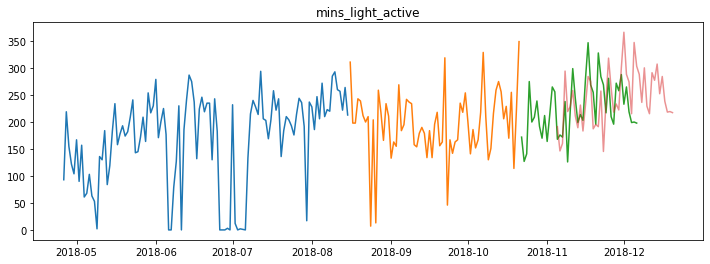

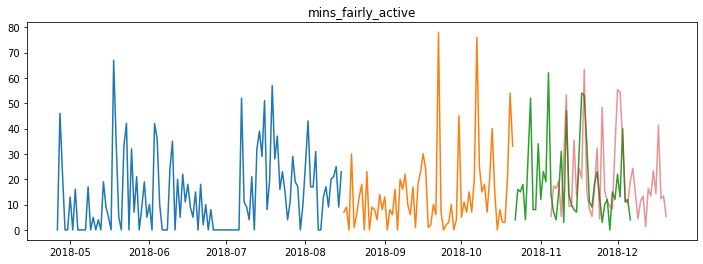

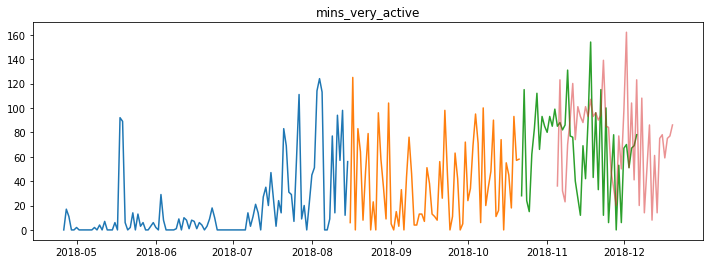

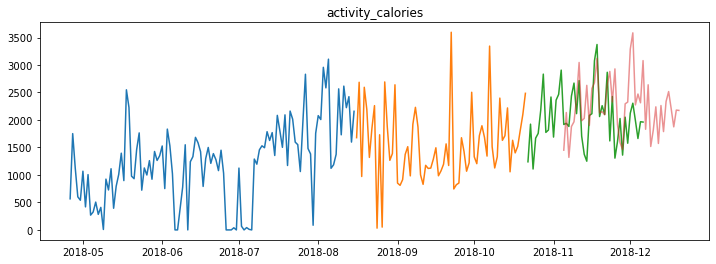

In [61]:
for col in train.columns:
    final_plot(col)